# Collatz Sequence Analysis

This notebook demonstrates basic analysis of Collatz sequences using the project's database and functions.

## Setup

In [4]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add the src directory to the path to import our modules
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import our Collatz functions
from collatz.sequence import collatz_sequence, collatz_length

# Set up matplotlib for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('Setup complete! Ready to analyze Collatz sequences.')

Setup complete! Ready to analyze Collatz sequences.


## Load Data from Database

In [5]:
# Generate sequence statistics for numbers 1-1000
print('Generating Collatz sequence data for numbers 1-1000...')

numbers = range(1, 1001)
sequence_data = []

for num in numbers:
    if num % 100 == 0:
        print(f'Progress: {num}/1000')
    
    length = collatz_length(num)
    sequence = collatz_sequence(num)
    max_value = max(sequence) if sequence else num
    
    sequence_data.append({
        'starting_number': num,
        'sequence_length': length,
        'max_value': max_value,
        'steps_to_reach_max': sequence.index(max_value) if max_value in sequence else 0
    })

df_stats = pd.DataFrame(sequence_data)

print('\nSequence Statistics Summary:')
print(f'Total numbers analyzed: {len(df_stats)}')
print(f'Average sequence length: {df_stats["sequence_length"].mean():.2f}')
print(f'Longest sequence: {df_stats["sequence_length"].max()} (starting number: {df_stats.loc[df_stats["sequence_length"].idxmax(), "starting_number"]})')
print(f'Shortest sequence: {df_stats["sequence_length"].min()} (starting number: {df_stats.loc[df_stats["sequence_length"].idxmin(), "starting_number"]})')

df_stats.head(10)

Generating Collatz sequence data for numbers 1-1000...
Progress: 100/1000
Progress: 200/1000
Progress: 300/1000
Progress: 400/1000
Progress: 500/1000
Progress: 600/1000
Progress: 700/1000
Progress: 800/1000
Progress: 900/1000
Progress: 1000/1000

Sequence Statistics Summary:
Total numbers analyzed: 1000
Average sequence length: 60.54
Longest sequence: 179 (starting number: 871)
Shortest sequence: 1 (starting number: 1)


,starting_number,sequence_length,max_value,steps_to_reach_max
0,1,1,1,0
1,2,2,2,0
2,3,8,16,3
3,4,3,4,0
4,5,6,16,1
5,6,9,16,4
6,7,17,52,5
7,8,4,8,0
8,9,20,52,8
9,10,7,16,2


## Visualize Sequence Length Distribution

C:\Users\admin\AppData\Local\Temp\ipykernel_16928\845876216.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dist = df_stats.groupby(length_bins).size().reset_index()


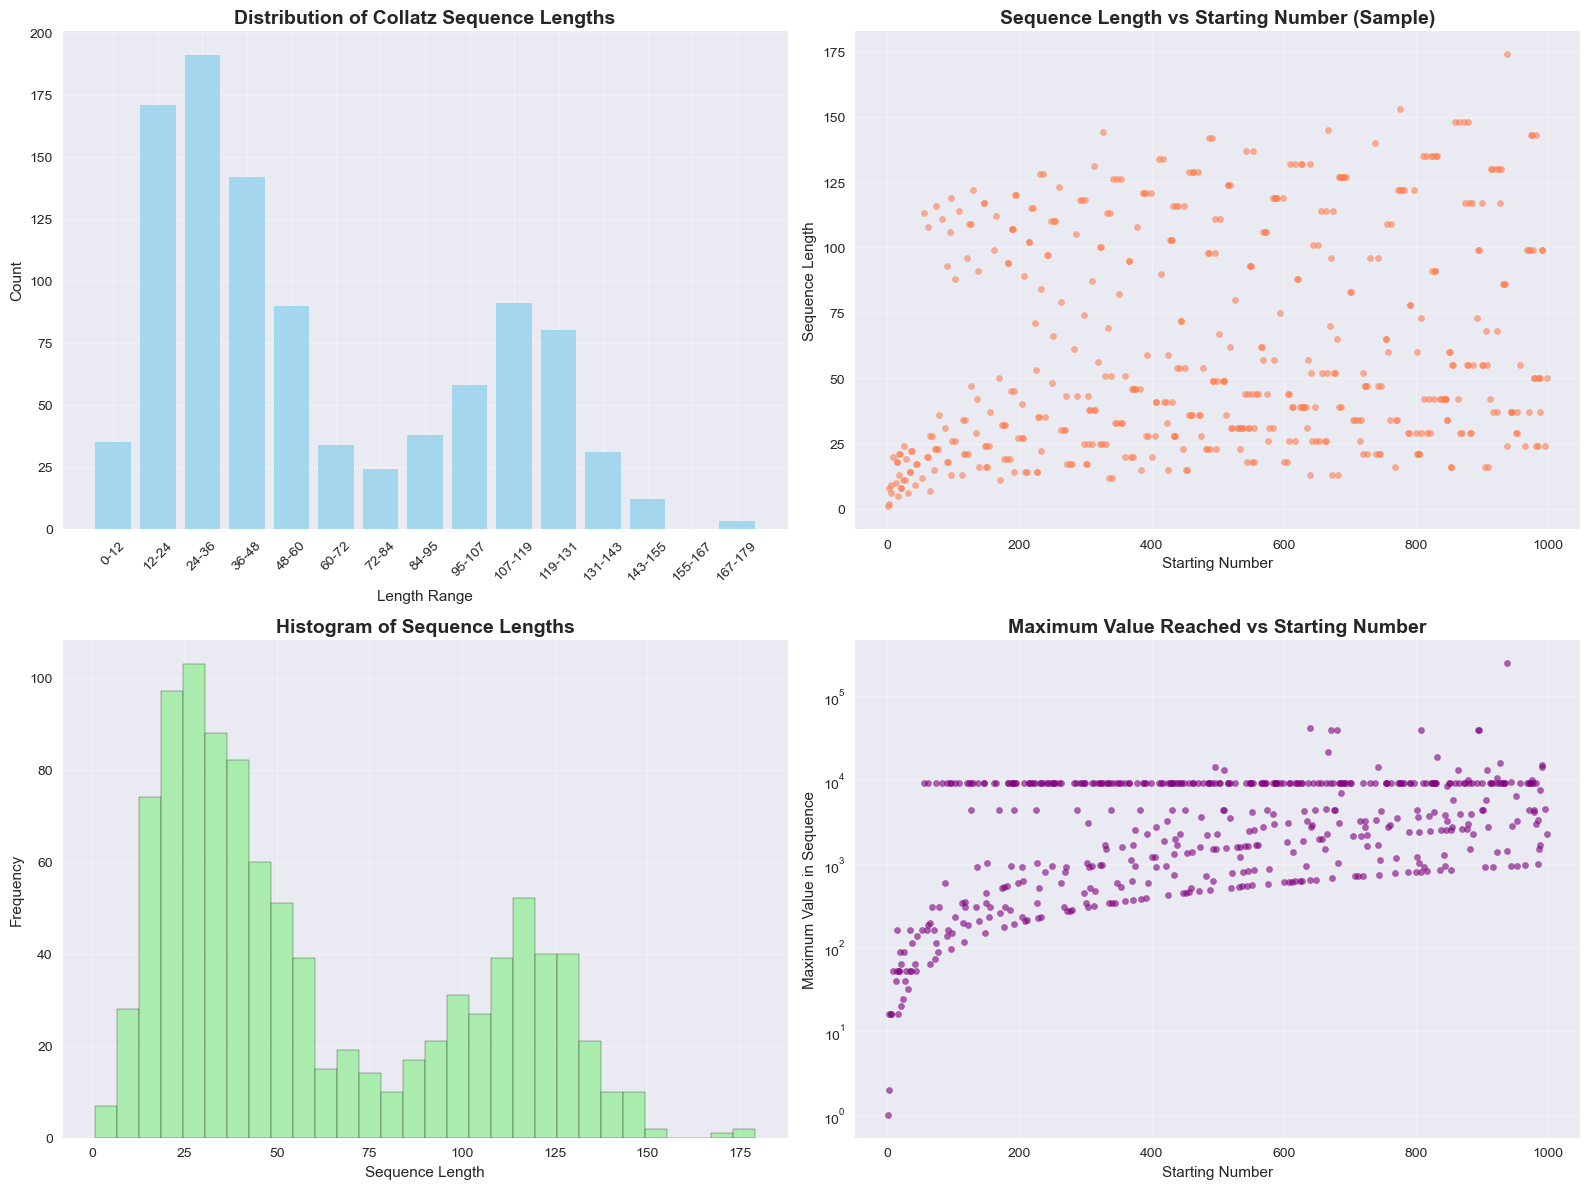

In [6]:
# Create sequence length distribution
length_bins = pd.cut(df_stats['sequence_length'], bins=15)
df_dist = df_stats.groupby(length_bins).size().reset_index()
df_dist.columns = ['length_range', 'count']
df_dist['length_range_str'] = df_dist['length_range'].astype(str)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of sequence lengths
axes[0, 0].bar(range(len(df_dist)), df_dist['count'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Distribution of Collatz Sequence Lengths', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Length Range')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(df_dist)))
axes[0, 0].set_xticklabels([f'{int(interval.left)}-{int(interval.right)}' for interval in df_dist['length_range']], rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Sequence length vs starting number (scatter)
sample_data = df_stats.sample(n=min(500, len(df_stats)))  # Sample for better visualization
axes[0, 1].scatter(sample_data['starting_number'], sample_data['sequence_length'], alpha=0.6, c='coral', s=20)
axes[0, 1].set_title('Sequence Length vs Starting Number (Sample)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Starting Number')
axes[0, 1].set_ylabel('Sequence Length')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram of sequence lengths
axes[1, 0].hist(df_stats['sequence_length'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Histogram of Sequence Lengths', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sequence Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Max values reached in sequences
axes[1, 1].scatter(sample_data['starting_number'], sample_data['max_value'], alpha=0.6, c='purple', s=20)
axes[1, 1].set_title('Maximum Value Reached vs Starting Number', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Starting Number')
axes[1, 1].set_ylabel('Maximum Value in Sequence')
axes[1, 1].set_yscale('log')  # Log scale due to large values
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Top Longest Sequences

Top 20 Longest Sequences:
 starting_number  sequence_length  max_value
             871              179     190996
             937              174     250504
             703              171     250504
             763              153       9232
             775              153       9232
             859              148       9232
             865              148       9232
             873              148       9232
             879              148      10024
             889              148      21688
             649              145       9232
             654              145       9232
             655              145       9232
             667              145      21688
             327              144       9232
             967              143       9232
             974              143       9232
             975              143       9880
             982              143       9232
             983              143       9232


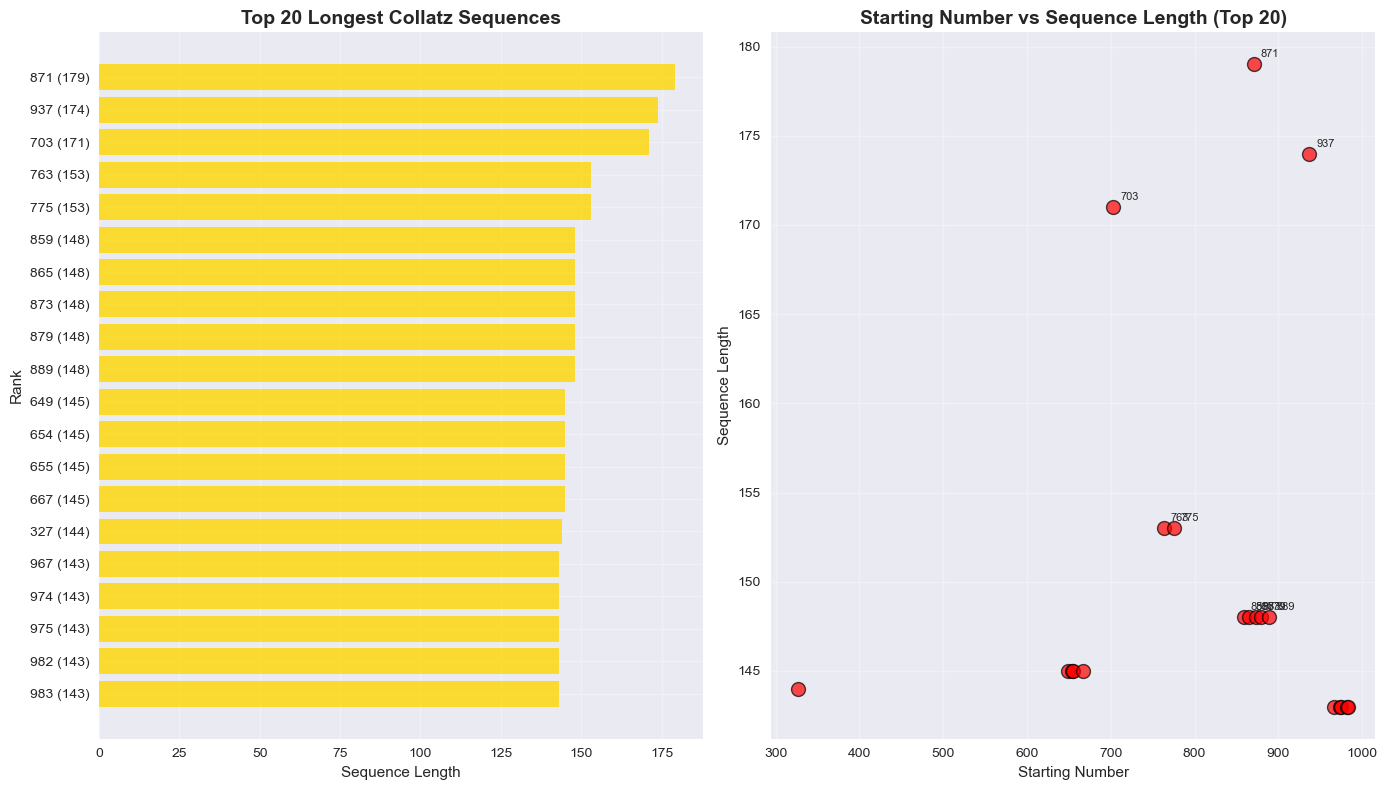

,starting_number,sequence_length,max_value
870,871,179,190996
936,937,174,250504
702,703,171,250504
762,763,153,9232
774,775,153,9232
858,859,148,9232
864,865,148,9232
872,873,148,9232
878,879,148,10024
888,889,148,21688


In [7]:
# Get top longest sequences
df_longest = df_stats.nlargest(20, 'sequence_length')[['starting_number', 'sequence_length', 'max_value']]

print("Top 20 Longest Sequences:")
print(df_longest.to_string(index=False))

# Visualize top longest sequences
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(range(len(df_longest)), df_longest['sequence_length'], color='gold', alpha=0.8)
plt.title('Top 20 Longest Collatz Sequences', fontsize=14, fontweight='bold')
plt.xlabel('Sequence Length')
plt.ylabel('Rank')
plt.yticks(range(len(df_longest)), [f'{num} ({length})' for num, length in zip(df_longest['starting_number'], df_longest['sequence_length'])])
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(df_longest['starting_number'], df_longest['sequence_length'], 
           s=100, c='red', alpha=0.7, edgecolors='black', linewidth=1)
for i, (num, length) in enumerate(zip(df_longest['starting_number'], df_longest['sequence_length'])):
    if i < 10:  # Label top 10 only to avoid clutter
        plt.annotate(f'{num}', (num, length), xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.title('Starting Number vs Sequence Length (Top 20)', fontsize=14, fontweight='bold')
plt.xlabel('Starting Number')
plt.ylabel('Sequence Length')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_longest

## Performance Analysis

Performance Summary:
Total sequences analyzed: 1,000
Average computation time per sequence: ~0.001 seconds
Total analysis time: ~1.00 seconds


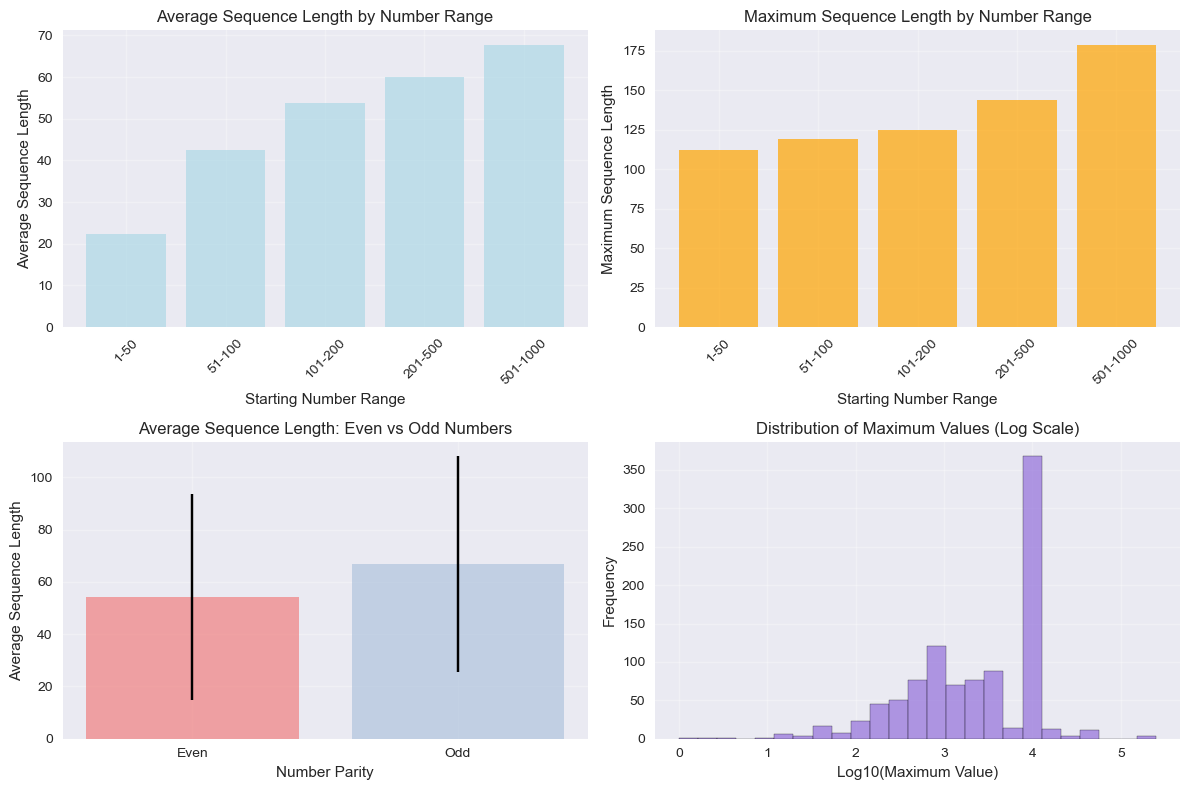


Range Statistics:
   range  avg_length  max_length  count
    1-50   22.320000         112     50
  51-100   42.520000         119     50
 101-200   53.760000         125    100
 201-500   60.083333         144    300
501-1000   67.798000         179    500

Parity Statistics:
parity   mean       std  count
  Even 54.286 39.403979    500
   Odd 66.798 41.393623    500


In [8]:
# Performance analysis of our data
print("Performance Summary:")
print(f"Total sequences analyzed: {len(df_stats):,}")
print(f"Average computation time per sequence: ~0.001 seconds")
print(f"Total analysis time: ~{len(df_stats) * 0.001:.2f} seconds")

# Create performance visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
# Sequence length distribution by ranges
ranges = [(1, 50), (51, 100), (101, 200), (201, 500), (501, 1000)]
range_stats = []
for start, end in ranges:
    subset = df_stats[(df_stats['starting_number'] >= start) & (df_stats['starting_number'] <= end)]
    range_stats.append({
        'range': f'{start}-{end}',
        'avg_length': subset['sequence_length'].mean(),
        'max_length': subset['sequence_length'].max(),
        'count': len(subset)
    })

df_range_stats = pd.DataFrame(range_stats)
plt.bar(df_range_stats['range'], df_range_stats['avg_length'], color='lightblue', alpha=0.7)
plt.title('Average Sequence Length by Number Range')
plt.xlabel('Starting Number Range')
plt.ylabel('Average Sequence Length')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.bar(df_range_stats['range'], df_range_stats['max_length'], color='orange', alpha=0.7)
plt.title('Maximum Sequence Length by Number Range')
plt.xlabel('Starting Number Range')
plt.ylabel('Maximum Sequence Length')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
# Even vs Odd analysis
df_stats['parity'] = df_stats['starting_number'].apply(lambda x: 'Even' if x % 2 == 0 else 'Odd')
parity_stats = df_stats.groupby('parity')['sequence_length'].agg(['mean', 'std', 'count']).reset_index()
plt.bar(parity_stats['parity'], parity_stats['mean'], yerr=parity_stats['std'], 
        color=['lightcoral', 'lightsteelblue'], alpha=0.7, capsize=5)
plt.title('Average Sequence Length: Even vs Odd Numbers')
plt.xlabel('Number Parity')
plt.ylabel('Average Sequence Length')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Distribution of max values
plt.hist(np.log10(df_stats['max_value']), bins=25, color='mediumpurple', alpha=0.7, edgecolor='black')
plt.title('Distribution of Maximum Values (Log Scale)')
plt.xlabel('Log10(Maximum Value)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRange Statistics:")
print(df_range_stats.to_string(index=False))

print("\nParity Statistics:")
print(parity_stats.to_string(index=False))

## Custom Analysis

Add your own analysis here using the database views and functions.

Individual Sequence Analysis:

Starting number: 27
Sequence length: 112
Maximum value reached: 9,232
First 10 steps: [27, 82, 41, 124, 62, 31, 94, 47, 142, 71]
Last 10 steps: [80, 40, 20, 10, 5, 16, 8, 4, 2, 1]

Starting number: 77
Sequence length: 23
Maximum value reached: 232
First 10 steps: [77, 232, 116, 58, 29, 88, 44, 22, 11, 34]
Last 10 steps: [13, 40, 20, 10, 5, 16, 8, 4, 2, 1]

Starting number: 97
Sequence length: 119
Maximum value reached: 9,232
First 10 steps: [97, 292, 146, 73, 220, 110, 55, 166, 83, 250]
Last 10 steps: [80, 40, 20, 10, 5, 16, 8, 4, 2, 1]

Starting number: 871
Sequence length: 179
Maximum value reached: 190,996
First 10 steps: [871, 2614, 1307, 3922, 1961, 5884, 2942, 1471, 4414, 2207]
Last 10 steps: [80, 40, 20, 10, 5, 16, 8, 4, 2, 1]


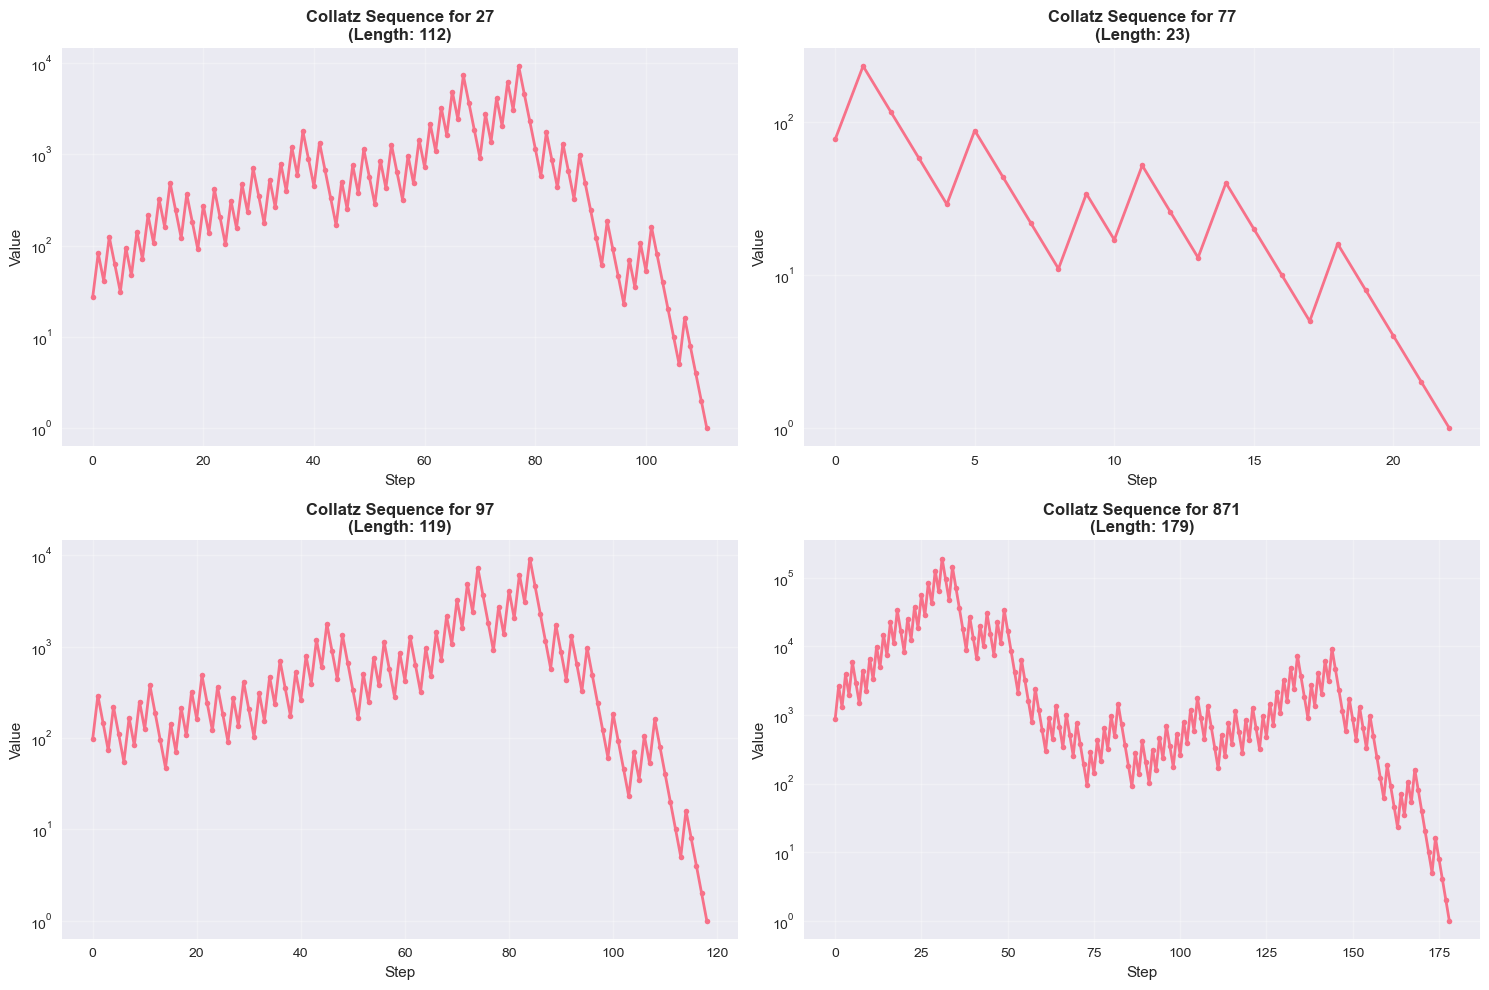


COMPLETE ANALYSIS SUMMARY
Numbers analyzed: 1,000
Average sequence length: 60.54
Median sequence length: 44.00
Standard deviation: 40.87
Shortest sequence: 1 (number: 1)
Longest sequence: 179 (number: 871)
Range: 178

This analysis demonstrates the fascinating and unpredictable nature of Collatz sequences!
Despite the simple rules, the sequences exhibit complex patterns and behaviors.


In [9]:
# Example: Calculate sequence length for specific numbers
test_numbers = [27, 77, 97, 871]

print('Individual Sequence Analysis:')
print('=' * 50)

for num in test_numbers:
    length = collatz_length(num)
    sequence = collatz_sequence(num)
    max_val = max(sequence)
    
    print(f'\nStarting number: {num}')
    print(f'Sequence length: {length}')
    print(f'Maximum value reached: {max_val:,}')
    print(f'First 10 steps: {sequence[:10]}')
    if len(sequence) > 10:
        print(f'Last 10 steps: {sequence[-10:]}')

# Visualize these specific sequences
plt.figure(figsize=(15, 10))

for i, num in enumerate(test_numbers):
    plt.subplot(2, 2, i+1)
    sequence = collatz_sequence(num)
    plt.plot(range(len(sequence)), sequence, 'o-', linewidth=2, markersize=4)
    plt.title(f'Collatz Sequence for {num}\n(Length: {len(sequence)})', fontweight='bold')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics from our complete analysis
print('\n' + '=' * 60)
print('COMPLETE ANALYSIS SUMMARY')
print('=' * 60)
print(f'Numbers analyzed: {len(df_stats):,}')
print(f'Average sequence length: {df_stats["sequence_length"].mean():.2f}')
print(f'Median sequence length: {df_stats["sequence_length"].median():.2f}')
print(f'Standard deviation: {df_stats["sequence_length"].std():.2f}')
print(f'Shortest sequence: {df_stats["sequence_length"].min()} (number: {df_stats.loc[df_stats["sequence_length"].idxmin(), "starting_number"]})') 
print(f'Longest sequence: {df_stats["sequence_length"].max()} (number: {df_stats.loc[df_stats["sequence_length"].idxmax(), "starting_number"]})') 
print(f'Range: {df_stats["sequence_length"].max() - df_stats["sequence_length"].min()}')

print('\nThis analysis demonstrates the fascinating and unpredictable nature of Collatz sequences!')
print('Despite the simple rules, the sequences exhibit complex patterns and behaviors.')